### Price Optimization  
  
An example. Based on this [source](https://medium.com/priceloop-tech-blog/building-and-integration-of-a-simple-ml-price-optimization-model-into-priceloop-nocode-3f6e444d6207)  
  
**Input data**  
* `tables` loaded from this [repo](https://github.com/priceloop/nocode-ml-example/tree/main/data)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_partregress_grid

In [20]:
# Load data
url1 = "https://raw.githubusercontent.com/priceloop/nocode-ml-example/main/data/Cafe%20-%20Sell%20Meta%20Data.csv"
url2 = "https://raw.githubusercontent.com/priceloop/nocode-ml-example/main/data/Cafe%20-%20Transaction%20-%20Store.csv"
category_data = pd.read_csv(url1)
transaction_data = pd.read_csv(url2)

In [21]:
category_data["SELL_ID"] = category_data["SELL_ID"].astype(str)
category_data["SELL_CATEGORY"] = category_data["SELL_CATEGORY"].astype(str)
category_data["ITEM_ID"] = category_data["ITEM_ID"].astype(str)
category_data["ITEM_NAME"] = category_data["ITEM_NAME"].astype(str)

In [22]:
category_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SELL_ID        11 non-null     object 
 1   SELL_CATEGORY  11 non-null     object 
 2   ITEM_ID        11 non-null     object 
 3   ITEM_NAME      11 non-null     object 
 4   COSTS          11 non-null     float64
 5   MIN_PRICE      11 non-null     float64
 6   MAX_PRICE      11 non-null     float64
dtypes: float64(3), object(4)
memory usage: 744.0+ bytes


In [23]:
category_data.head()

,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME,COSTS,MIN_PRICE,MAX_PRICE
0,1070,0,7821,BURGER,8.0,9.6,24.6
1,3055,0,3052,COFFEE,1.0,1.2,16.2
2,3067,0,5030,COKE,3.0,3.6,18.6
3,3028,0,6249,LEMONADE,2.0,2.4,17.4
4,2051,2,7821,BURGER,6.0,7.2,22.2


In [30]:
transaction_data["STORE"] = transaction_data["STORE"].astype(str)
transaction_data["CALENDAR_DATE"] = pd.to_datetime(transaction_data["CALENDAR_DATE"])
transaction_data["SELL_ID"] = transaction_data["SELL_ID"].astype(str)
transaction_data["SELL_CATEGORY"] = transaction_data["SELL_CATEGORY"].astype(str)

In [31]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   STORE          5404 non-null   object        
 1   CALENDAR_DATE  5404 non-null   datetime64[ns]
 2   PRICE          5404 non-null   float64       
 3   QUANTITY       5404 non-null   int64         
 4   SELL_ID        5404 non-null   object        
 5   SELL_CATEGORY  5404 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 253.4+ KB


In [34]:
transaction_data.shape

(5404, 6)

In [32]:
transaction_data.head()

,STORE,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
0,1,2012-01-01,15.50,46,1070,0
1,1,2012-01-01,12.73,22,2051,2
2,1,2012-01-01,12.75,18,2052,2
3,1,2012-01-01,12.60,30,2053,2
4,1,2012-01-02,15.50,70,1070,0


In [33]:
# check for null values in the fact data
transaction_data[transaction_data.isnull().any(axis=1)]

,STORE,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY


In [36]:
# check for dupliates
transaction_data[transaction_data.duplicated()]

,STORE,CALENDAR_DATE,PRICE,QUANTITY,SELL_ID,SELL_CATEGORY
1704,1,2013-03-01,15.50,90,1070,0
1710,1,2013-03-01,13.41,40,2052,2
1711,1,2013-03-01,13.41,40,2053,2


In [38]:
# drop dups
transaction_data = transaction_data.drop_duplicates()

In [39]:
# merge category data with the fact table
data = pd.merge(category_data, transaction_data.drop(columns=["SELL_CATEGORY"]), on="SELL_ID")
data.head()

,SELL_ID,SELL_CATEGORY,ITEM_ID,ITEM_NAME,COSTS,MIN_PRICE,MAX_PRICE,STORE,CALENDAR_DATE,PRICE,QUANTITY
0,1070,0,7821,BURGER,8.0,9.6,24.6,1,2012-01-01,15.5,46
1,1070,0,7821,BURGER,8.0,9.6,24.6,1,2012-01-02,15.5,70
2,1070,0,7821,BURGER,8.0,9.6,24.6,1,2012-01-03,15.5,62
3,1070,0,7821,BURGER,8.0,9.6,24.6,1,2012-01-04,15.5,88
4,1070,0,7821,BURGER,8.0,9.6,24.6,1,2012-01-05,15.5,104


In [41]:
# Group and sum quanityt of data due to multiple transactions per day for each SELL_ID
cleaned_data = data.groupby(["SELL_ID","SELL_CATEGORY","ITEM_NAME","CALENDAR_DATE","PRICE","COSTS"]).QUANTITY.sum()
cleaned_data = cleaned_data.reset_index()
cleaned_data.head()

,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,COSTS,QUANTITY
0,1070,0,BURGER,2012-01-01,15.5,8.0,46
1,1070,0,BURGER,2012-01-02,15.5,8.0,70
2,1070,0,BURGER,2012-01-03,15.5,8.0,62
3,1070,0,BURGER,2012-01-04,15.5,8.0,88
4,1070,0,BURGER,2012-01-05,15.5,8.0,104


### Estimate the elasticity model for one SELL_ID first. Take the "1070" item.

In [45]:
burger_1070 = cleaned_data[cleaned_data["SELL_ID"] == "1070"]
burger_1070.shape

(1349, 7)

In [47]:
# fit ols from stats models api
burger_1070_model = ols("QUANTITY ~ PRICE", data=burger_1070).fit()

print(burger_1070_model.summary())

                            OLS Regression Results                            
Dep. Variable:               QUANTITY   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     177.1
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           4.76e-38
Time:                        15:14:54   Log-Likelihood:                -5606.2
No. Observations:                1349   AIC:                         1.122e+04
Df Residuals:                    1347   BIC:                         1.123e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    194.8558      8.533     22.836      0.0

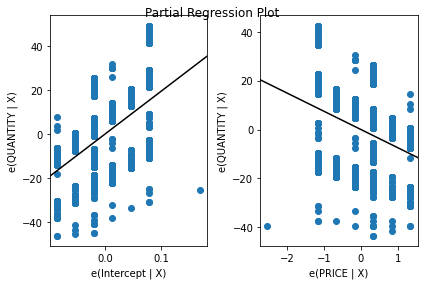

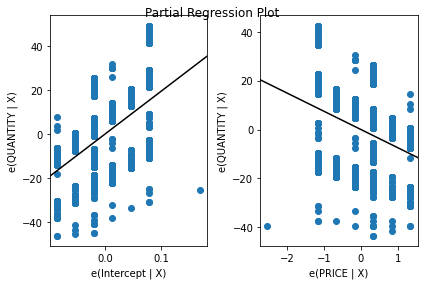

In [48]:
# The elasticityis about -7 and the r2 is quite low, indicating this model is not good
# but for the sake of this example we will use it

# plot
plot_partregress_grid(burger_1070_model)

### Next we estimate elasticities for all combinations

In [49]:
model_elasticity = {}

In [50]:
# estimate func
def create_model_and_find_elasticity(data):
  model = ols("QUANTITY ~ PRICE", data).fit()
  price_elasticity = model.params[1]
  return price_elasticity, model

In [54]:
# iterate over all items
for i, df in cleaned_data.groupby(["SELL_ID","ITEM_NAME"]):
  # print(i)
  # print(df)
  e, model = create_model_and_find_elasticity(df)
  model_elasticity[i] = (e, model)

In [55]:
# check the sign of the elasticities. seem to be all negative, which is good
model_elasticity

{('1070', 'BURGER'): (-7.478107135366491,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f46559de090>),
 ('2051', 'BURGER'): (-1.9128005756803474,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f4658800c50>),
 ('2051', 'COKE'): (-1.9128005756803474,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f4655e6f310>),
 ('2052', 'BURGER'): (-2.271811473474674,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f46559e6850>),
 ('2052', 'LEMONADE'): (-2.271811473474674,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f4655990d10>),
 ('2053', 'BURGER'): (-5.226102393167876,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f4658852650>),
 ('2053', 'COFFEE'): (-5.226102393167876,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f46559d4d10>),
 ('2053', 'COKE'): (-5.226102393167876,
  <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x

###Then we find the optimal price where max profit is the highest first for SELL_ID 1070

In [57]:
burger_1070 = cleaned_data[cleaned_data["SELL_ID"] == "1070"]
print(burger_1070.shape)
burger_1070.head()

(1349, 7)


,SELL_ID,SELL_CATEGORY,ITEM_NAME,CALENDAR_DATE,PRICE,COSTS,QUANTITY
0,1070,0,BURGER,2012-01-01,15.5,8.0,46
1,1070,0,BURGER,2012-01-02,15.5,8.0,70
2,1070,0,BURGER,2012-01-03,15.5,8.0,62
3,1070,0,BURGER,2012-01-04,15.5,8.0,88
4,1070,0,BURGER,2012-01-05,15.5,8.0,104


In [68]:
burger_1070.PRICE.min(), burger_1070.PRICE.max(), burger_1070.COSTS.unique()[0]

(12.64, 16.5, 8.0)

In [70]:
burger_1070.describe()

,PRICE,COSTS,QUANTITY
count,1349.000000,1349.0,1349.000000
mean,15.165041,8.0,81.449963
std,0.748800,0.0,16.428152
min,12.640000,8.0,38.000000
25%,14.500000,8.0,66.000000
50%,15.500000,8.0,84.000000
75%,15.500000,8.0,92.000000
max,16.500000,8.0,124.000000


In [71]:
# set some start and end price points
start_price = 8.5
end_price= 25

In [79]:
opt_price_table = pd.DataFrame(columns = ["PRICE", "QUANTITY"])
opt_price_table["PRICE"] = np.arange(start_price, end_price, 0.01) # 1650 points with 0.01 steps from start to end_price
opt_price_table["QUANTITY"] = model_elasticity[("1070", "BURGER")][1].predict(opt_price_table["PRICE"]) # Call predict call for all 1650
opt_price_table["PROFIT"] = (opt_price_table["PRICE"] - burger_1070.COSTS.unique()[0]) * opt_price_table["QUANTITY"]
print(opt_price_table.shape)
opt_price_table.head()

(1650, 3)


,PRICE,QUANTITY,PROFIT
0,8.50,131.291852,65.645926
1,8.51,131.217071,66.920706
2,8.52,131.142290,68.193991
3,8.53,131.067509,69.465780
4,8.54,130.992728,70.736073


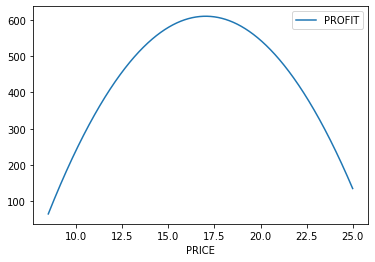

In [80]:
opt_price_table.plot("PRICE", "PROFIT")

In [81]:
# Find the optimal price for this item
ind = np.where(opt_price_table["PROFIT"] == opt_price_table["PROFIT"].max())[0][0]
opt_price_table.loc[[ind]]

,PRICE,QUANTITY,PROFIT
853,17.03,67.503598,609.55749


### Finding the optimal price for all products

In [82]:
# ...